# Imports

In [3]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from itertools import combinations
import random
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
import random
import statsmodels.api as sm
from sklearn.feature_selection import VarianceThreshold
import warnings
import shap
import copy
warnings.filterwarnings("ignore")

# Step1: Data generation using one pair of feature interactions

In [4]:
# utils
def oh_encode_data(df, cols):
    encoder = OneHotEncoder(sparse=False)
    encoded_df = pd.DataFrame(encoder.fit_transform(df[cols]), index=df.index)
    encoded_df.columns = encoder.get_feature_names_out(cols)

    return encoded_df

def model_notation(columns):
    """
    Encodes a list of column names into a model notation string.
    The notation follows the format 'y ~ x1 + x2 + x3' for simple columns,
    and 'y ~ x1 * x2 + x3' for interaction terms.
    """
    terms = []
    for col in sorted(columns):
        if '_' in col:
            col = col.split('_')
            col = [s[0].upper() for s in col]
            terms.append("*".join(col))
        else:
            terms.append(col[0].upper())
    model_notation = 'S ~ ' + ' + '.join(terms)
    return model_notation

In [5]:
# main data generation
def generate_data(n=1000):
    np.random.seed(0)

    data = {
        'age': np.random.choice(age_levels, n),
        'work': np.random.choice(work_levels, n),
        'education': np.random.choice(education_levels, n),
        'country': np.random.choice(country_codes, n),
        'race': np.random.choice(races, n),
        'gender': np.random.choice(genders, n),
        'maritalStatus': np.random.choice(marital_statuses, n),
        'occupation': np.random.choice(occupations, n),
        # 'occupation': np.random.choice(occupations_minus_ceo, n),
    }
    df = pd.DataFrame(data)

    # Enforce 50% married women
    # married_female_indices = np.random.choice(df.index, size=int(n * 0.5), replace=False) ????
    # df.loc[married_female_indices, 'maritalStatus'] = 'married'
    # df.loc[married_female_indices, 'gender'] = 'F'

    # keep #ceos small
    # ceo_indices = np.random.choice(df.index, size=int(n * 0.01), replace=False) # bad for rand gen sampling
    # df.loc[ceo_indices, 'occupation'] = 'CEO'

    df['occupationWeight'] = df['occupation'].map(occupation_weights)
    df['educationWeight'] = df['education'].map(education_level_weights)
    df['workWeight'] = df['work'].map(work_class_weights)
    df['countryWeight'] = df['country'].apply(lambda x: country_weights[country_codes.index(x)])
    df['maritalStatus_gender'] = df['maritalStatus'] + '_' + df['gender']
    df['maritalStatus_genderWeight'] = df['maritalStatus_gender'].map(marital_status_gender_weights)

    df['salary'] = (df['occupationWeight'] + df['maritalStatus_genderWeight'] +
                    df['educationWeight'] + df['workWeight'] +
                    df['countryWeight']) * 8000
    # add noise
    df['salary'] += np.random.normal(0, 3000, n)

    df.drop(columns=['occupationWeight', 'educationWeight', 'workWeight',
                     'countryWeight', 'maritalStatus_gender', 'maritalStatus_genderWeight'],
            inplace=True)

    print("internal model made from:", model_notation(['occupation', 'education', 'work', 'country',
                                                       'maritalStatus_gender']))

    return df

In [6]:
age_levels = ['19-30', '31-49', '50-70']
education_levels = ['school', 'bachelors', 'masters+']
work_levels = ['private', 'public', 'self']
country_codes = ['US', 'GB', 'CA', 'FR', 'DE', 'JP', 'CN', 'IN', 'BR', 'RU',
                 'IT', 'AU', 'ZA', 'ES', 'KR', 'SE', 'CH', 'TR', 'NL', 'MX']
races = ['W', 'B', 'A']
genders = ['M', 'F']
marital_statuses = ['single', 'married', 'divorced']
occupations = ['sales', 'custserv', 'clerk', 'cashier', 'sec', 'teacher',
               'nurse', 'account', 'dev', 'eng', 'doc', 'CEO']
# occupations_minus_ceo = ['Sales', 'CustServ', 'Clerk', 'Cashier', 'Sec', 'Teacher',
            #    'Nurse', 'Account', 'Dev', 'Eng', 'Doc']
occupation_weights = {
    'CEO': 12, 'eng': 6, 'doc': 6, 'dev': 5,
    'sales': 2, 'custserv': 1, 'clerk': 1, 'cashier': 2, 'sec': 1.5, 'teacher': 3,
    'nurse': 4, 'account': 5.5
}
# skewed weights for female based on marital_status
marital_status_gender_weights = { 'married_F': 4, 'married_M': 16, 'single_F': 20, 'single_M': 18, 'divorced_F': 15, 'divorced_M': 14}
education_level_weights = {'school': 3, 'bachelors': 4, 'masters+': 6}
work_class_weights = {'private': 1, 'public': 1.5, 'self': 2}
country_weights = np.linspace(0, 1, 20)

# Generate dataset
np.random.seed(0)  # For reproducibility
data = generate_data(3000)
print(f"average salary: {int(data['salary'].mean())}")
input_data = data.drop('salary', axis = 1)

encoder = OneHotEncoder(sparse = False)
X = encoder.fit_transform(data.drop('salary', axis=1))
y = data['salary'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

reg = LinearRegression()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"R2 of naive full model with base features:{r2:.5f}, MSE:{mse:.1f}")

internal model made from: S ~ C + E + M*G + O + W
average salary: 198723
R2 of naive full model with base features:0.70406, MSE:654623722.4


In [7]:
data.head()

,age,work,education,country,race,gender,maritalStatus,occupation,salary
0,19-30,self,masters+,GB,A,M,married,nurse,226962.793734
1,31-49,public,school,BR,W,M,divorced,clerk,161587.016963
2,19-30,private,masters+,SE,B,F,divorced,teacher,206954.825733
3,31-49,self,bachelors,FR,A,F,married,doc,130732.454899
4,31-49,public,bachelors,MX,W,M,married,clerk,190698.246332


# Step: 2 Greedy Search

In [8]:
def add_n_combinations_of_2(data):
    '''function used for generating the combination columns
    the final data (refined_data) has list of n plus nc2 combinations'''
    refined_data = data.copy()
    column_names = refined_data.columns
    combinations_2 = list(combinations(column_names, 2))
    for combo in combinations_2:
        new_column_name = f"{combo[0]}_{combo[1]}"
        refined_data[new_column_name] = refined_data[combo[0]] + "_" + refined_data[combo[1]]
    return refined_data

In [9]:
X = data.drop('salary', axis=1)
y = data['salary'].values
X_combination = add_n_combinations_of_2(X)

In [10]:
X_combination.head()

,age,work,education,country,race,gender,maritalStatus,occupation,age_work,age_education,...,country_race,country_gender,country_maritalStatus,country_occupation,race_gender,race_maritalStatus,race_occupation,gender_maritalStatus,gender_occupation,maritalStatus_occupation
0,19-30,self,masters+,GB,A,M,married,nurse,19-30_self,19-30_masters+,...,GB_A,GB_M,GB_married,GB_nurse,A_M,A_married,A_nurse,M_married,M_nurse,married_nurse
1,31-49,public,school,BR,W,M,divorced,clerk,31-49_public,31-49_school,...,BR_W,BR_M,BR_divorced,BR_clerk,W_M,W_divorced,W_clerk,M_divorced,M_clerk,divorced_clerk
2,19-30,private,masters+,SE,B,F,divorced,teacher,19-30_private,19-30_masters+,...,SE_B,SE_F,SE_divorced,SE_teacher,B_F,B_divorced,B_teacher,F_divorced,F_teacher,divorced_teacher
3,31-49,self,bachelors,FR,A,F,married,doc,31-49_self,31-49_bachelors,...,FR_A,FR_F,FR_married,FR_doc,A_F,A_married,A_doc,F_married,F_doc,married_doc
4,31-49,public,bachelors,MX,W,M,married,clerk,31-49_public,31-49_bachelors,...,MX_W,MX_M,MX_married,MX_clerk,W_M,W_married,W_clerk,M_married,M_clerk,married_clerk


In [11]:
X_combination_ohe = oh_encode_data(X_combination, X_combination.columns)
X_combination_ohe.head()

,age_19-30,age_31-49,age_50-70,work_private,work_public,work_self,education_bachelors,education_masters+,education_school,country_AU,...,maritalStatus_occupation_single_cashier,maritalStatus_occupation_single_clerk,maritalStatus_occupation_single_custserv,maritalStatus_occupation_single_dev,maritalStatus_occupation_single_doc,maritalStatus_occupation_single_eng,maritalStatus_occupation_single_nurse,maritalStatus_occupation_single_sales,maritalStatus_occupation_single_sec,maritalStatus_occupation_single_teacher
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Step 2.1 Forward Selection

In [11]:
def forward_selection(X, y, significance_level=0.01):
    features = list(X.columns)
    selected_features = []

    print("Initial Selected Features count:",len(selected_features))

    # fit model on individual features
    best_feature_list = []
    for feature in features:
            # fit OLS for pvalue
            X_train, X_test, y_train, y_test = train_test_split(X[selected_features + [feature]], y, test_size=0.2, random_state=42)
            model = sm.OLS(y_train, sm.add_constant(X_train)).fit()  # add reguralizarion
            y_pred = model.predict(sm.add_constant(X_test))

            p_value = model.pvalues[feature]
            std_error = model.bse[feature]
            aic_score = model.aic
            mse = np.mean((y_test - y_pred)**2)
            r2 = model.rsquared
            llf = model.llf

            best_feature_list.append((feature,model,p_value,std_error,r2,mse,aic_score,llf))

    best_feature, model, p_value, std_error, r2, mse, aic_score, llf = min(best_feature_list, key=lambda x: (x[2],x[3]))


    selected_features.append(best_feature)
    features.remove(best_feature)

    print("Identified best feature:", best_feature)
    print("No of selected features:", len(selected_features))
    print("R-squared value:", r2)
    print("MSE:", mse)
    print("AIC Score:", aic_score)
    print("Loglikelyhood:", llf)
    print("")


    r2_list = [r2]
    mse_list = [mse]
    aic_list = [aic_score]
    loglikelyhood_list = [llf]
    optimal_model = model
    optimal_features = copy.copy(selected_features)

    min_pvalue = p_value

    while min_pvalue<significance_level:

        best_feature_list = []
        for feature in features:
                # fit OLS for pvalue
                X_train, X_test, y_train, y_test = train_test_split(X[selected_features + [feature]], y, test_size=0.2, random_state=42)
                model = sm.OLS(y_train, sm.add_constant(X_train)).fit()  # add reguralizarion
                y_pred = model.predict(sm.add_constant(X_test))

                p_value = model.pvalues[feature]
                std_error = model.bse[feature]
                aic_score = model.aic
                mse = np.mean((y_test - y_pred)**2)
                r2 = model.rsquared
                llf = model.llf

                best_feature_list.append((feature,model,p_value,std_error,r2,mse,aic_score,llf))

        best_feature_1, model_1, p_value_1,  std_error_1, r2_1, mse_1, aic_score_1, llf_1 = min(best_feature_list, key=lambda x: (x[2],x[3]))

        selected_features.append(best_feature_1)
        features.remove(best_feature_1)


        print("Identified best feature:", best_feature_1)
        print("No of selected features:", len(selected_features))
        print("R-squared value:", r2_1)
        print("MSE:", mse_1)
        print("AIC Score:", aic_score_1)
        print("Loglikelyhood:", llf_1)
        print("")

        r2_list.append(r2_1)
        mse_list.append(mse_1)
        aic_list.append(aic_score_1)
        loglikelyhood_list.append(llf_1)

        if (aic_score_1  <  aic_score + 5000) :
            optimal_model = model_1
            optimal_features = copy.copy(selected_features)
            aic_score = aic_score_1
            min_pvalue = p_value_1
            print(min_pvalue)

        else:
            break



    return optimal_features, optimal_model, r2_list, mse_list, aic_list, loglikelyhood_list

In [12]:
%%time
fs_selected_features, fs_optimal_model, fs_r2_list, fs_mse_list, fs_aic_list, fs_loglikelyhood_list = forward_selection(X_combination_ohe, y)

Initial Selected Features count: 0
Identified best feature: gender_maritalStatus_F_married
No of selected features: 1
R-squared value: 0.599605916168958
MSE: 875163045.7900602
AIC Score: 56478.92039901301
Loglikelyhood: -28237.460199506506

Identified best feature: occupation_CEO
No of selected features: 2
R-squared value: 0.7538895122263322
MSE: 610801910.5005486
AIC Score: 55312.915520708804
Loglikelyhood: -27653.457760354402

1.2789570263649322e-255
Identified best feature: maritalStatus_single
No of selected features: 3
R-squared value: 0.8393262319554164
MSE: 384586903.3438948
AIC Score: 54291.54460421666
Loglikelyhood: -27141.77230210833

3.888243799438543e-224
Identified best feature: education_masters+
No of selected features: 4
R-squared value: 0.8781194048212201
MSE: 292708619.34012246
AIC Score: 53630.34255678489
Loglikelyhood: -26810.171278392445

6.42392787937288e-146
Identified best feature: occupation_eng
No of selected features: 5
R-squared value: 0.8956089662468105
MSE

In [13]:
print("Forward selection selected coefficients: ",fs_selected_features)

Forward selection selected coefficients:  ['gender_maritalStatus_F_married', 'occupation_CEO', 'maritalStatus_single', 'education_masters+', 'occupation_eng', 'occupation_doc', 'occupation_account', 'occupation_dev', 'gender_maritalStatus_F_single', 'occupation_nurse', 'maritalStatus_married', 'education_school', 'maritalStatus_divorced', 'education_bachelors', 'gender_maritalStatus_M_married', 'occupation_teacher', 'gender_maritalStatus_M_single', 'work_self', 'gender_M', 'work_private', 'occupation_sales', 'occupation_cashier', 'country_NL', 'work_public', 'gender_maritalStatus_F_divorced', 'country_MX', 'country_TR', 'occupation_sec', 'country_GB', 'country_US', 'country_CH', 'country_CA', 'country_SE', 'country_KR', 'country_ES', 'country_FR', 'country_DE', 'country_maritalStatus_FR_married', 'country_ZA', 'country_IT', 'country_occupation_MX_sales', 'age_country_50-70_BR', 'education_country_masters+_AU', 'country_gender_RU_M', 'country_occupation_NL_clerk', 'country_race_GB_B', '

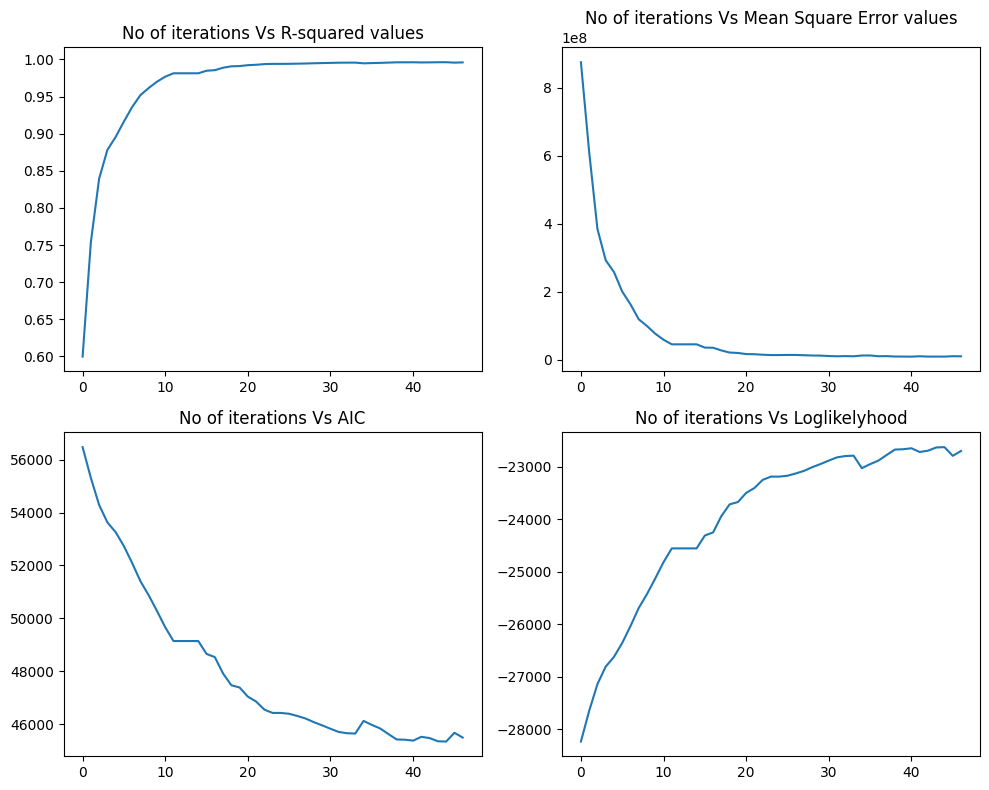

In [14]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

# Plot data on each subplot
axes[0, 0].plot(fs_r2_list)
axes[0, 0].set_title('No of iterations Vs R-squared values')

axes[0, 1].plot(fs_mse_list)
axes[0, 1].set_title('No of iterations Vs Mean Square Error values')

axes[1, 0].plot(fs_aic_list)
axes[1, 0].set_title('No of iterations Vs AIC')

axes[1, 1].plot(fs_loglikelyhood_list)
axes[1, 1].set_title('No of iterations Vs Loglikelyhood')

plt.tight_layout()
plt.show()


### A)Optimal model metrics on obtained coefficients

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_combination_ohe[fs_selected_features], y, test_size=0.2, random_state=42)
y_pred = fs_optimal_model.predict(sm.add_constant(X_test))
aic_score = fs_optimal_model.aic
mse = np.mean((y_test - y_pred)**2)
r2 = fs_optimal_model.rsquared
llf = fs_optimal_model.llf

print("Forward Selection Optimal R-squared value:", r2)
print("Forward Selection Optimal MSE:", mse)
print("Forward Selection Optimal AIC Score:", aic_score)
print("Forward Selection Optimal Log likelyhood",llf)

Forward Selection Optimal R-squared value: 0.9960286214325395
Forward Selection Optimal MSE: 9942269.185548922
Forward Selection Optimal AIC Score: 45486.91402049219
Forward Selection Optimal Log likelyhood -22701.457010246097


###  B) Final feature set from coefficients

In [18]:
fs_feature_check_list = []
fs_final_features = []
for key in fs_selected_features:
    feature_terms = key.split("_")
    if len(feature_terms) == 2:
        if feature_terms[0] not in fs_feature_check_list:
            fs_final_features.append(feature_terms[0])
            fs_feature_check_list.append(feature_terms[0])
    elif len(feature_terms) == 4:
        if feature_terms[0] not in fs_feature_check_list and feature_terms[1] not in fs_feature_check_list:
            fs_final_features.append('_'.join(feature_terms[:2]))
            fs_feature_check_list.append(feature_terms[0])
            fs_feature_check_list.append(feature_terms[1])

print("Forward selection selected features: ", fs_final_features)
print("Forward selection selected features in model notation: ",model_notation(fs_final_features))

Forward selection selected features:  ['gender_maritalStatus', 'occupation', 'education', 'work', 'country']
Forward selection selected features in model notation:  S ~ C + E + G*M + O + W


### C) Fitting linear model on final features

In [19]:
fs_X_combination_ohe = oh_encode_data(X_combination,fs_final_features)
X_train, X_test, y_train, y_test = train_test_split(fs_X_combination_ohe, y, test_size=0.2, random_state=42)
fs_final_model = sm.OLS(y_train, sm.add_constant(X_train)).fit()
y_pred = fs_final_model.predict(sm.add_constant(X_test))
aic_score = fs_final_model.aic
mse = np.mean((y_test - y_pred)**2)
r2 = fs_final_model.rsquared
llf = fs_final_model.llf

print("Forward selection on linear model R-squared value:", r2)
print("Forward selection on linear model MSE:", mse)
print("Forward selection on linear model AIC Score:", aic_score)
print("Forward selection on linear model Optimal Log likelyhood",llf)


Forward selection on linear model R-squared value: 0.9962799307344564
Forward selection on linear model MSE: 8837258.618054504
Forward selection on linear model AIC Score: 45326.02363788421
Forward selection on linear model Optimal Log likelyhood -22623.011818942105


## Step 2.2 Backward Elimination

In [12]:
def backward_elimination(X, y, significance_level = 0.01):
    selected_features = list(X.columns)

    print("Initial Selected Features count:",len(selected_features))

    # fitting with all features
    X_train, X_test, y_train, y_test = train_test_split(X[selected_features], y, test_size=0.2, random_state=42)
    model = sm.OLS(y_train, sm.add_constant(X_train)).fit()  # add reguralization
    y_pred = model.predict(sm.add_constant(X_test))
    p_value_list = model.pvalues
    std_error_list = model.bse
    aic_score = model.aic
    mse = np.mean((y_test - y_pred)**2)
    r2 = model.rsquared
    llf = model.llf

    print("R-squared value:", r2)
    print("MSE:", mse)
    print("AIC Score:", aic_score)
    print("Loglikelyhood:", llf)
    print("")


    r2_list = [r2]
    mse_list = [mse]
    aic_list = [aic_score]
    loglikelyhood_list = [llf]
    optimal_model = model
    optimal_features = copy.copy(selected_features)

    max_pvalue = max(p_value_list)
    while max_pvalue>significance_level:
        worst_feature_list = list(zip(selected_features, p_value_list, std_error_list))
        worst_feature,_,_ = max(worst_feature_list, key=lambda x: (x[1],x[2]))
        selected_features.remove(worst_feature)


        # fit OLS for AIC
        X_train, X_test, y_train, y_test = train_test_split(X[selected_features], y, test_size=0.2, random_state=42)
        model_1 = sm.OLS(y_train, sm.add_constant(X_train)).fit()  # add reguralization
        y_pred_1 = model_1.predict(sm.add_constant(X_test))
        p_value_list_1 = model_1.pvalues
        std_error_list_1 = model_1.bse
        aic_score_1 = model_1.aic
        mse_1 = np.mean((y_test - y_pred_1)**2)
        r2_1 = model_1.rsquared
        llf_1 = model_1.llf

        print("Identified worst feature:", worst_feature)
        print("No of selected features:", len(selected_features))
        print("R-squared value:", r2_1)
        print("MSE:", mse_1)
        print("AIC Score:", aic_score_1)
        print("Loglikelyhood:", llf_1)
        print("")

        r2_list.append(r2_1)
        mse_list.append(mse_1)
        aic_list.append(aic_score_1)
        loglikelyhood_list.append(llf_1)

        if (aic_score_1  <  aic_score + 5000) :
            optimal_model = model_1
            optimal_features = copy.copy(selected_features)
            aic_score = aic_score_1
            p_value_list = p_value_list_1
            std_error_list = std_error_list_1
            max_pvalue = max(p_value_list_1)
            print(max_pvalue)

        else:
            break



    return optimal_features, optimal_model, r2_list, mse_list, aic_list, loglikelyhood_list

In [13]:
%%time
be_selected_features, be_optimal_model, be_r2_list, be_mse_list, be_aic_list, be_loglikelyhood_list = backward_elimination(X_combination_ohe, y)

Initial Selected Features count: 953
R-squared value: 0.9969571682853597
MSE: 12275881.28267331
AIC Score: 46025.73470761058
Loglikelyhood: -22381.86735380529

Identified worst feature: country_maritalStatus_SE_divorced
No of selected features: 952
R-squared value: 0.9970882774444807
MSE: 11821190.678005654
AIC Score: 45920.029785844024
Loglikelyhood: -22329.014892922012

0.9987050155763417
Identified worst feature: country_occupation_IN_CEO
No of selected features: 951
R-squared value: 0.9968336929027359
MSE: 12595115.530175686
AIC Score: 46121.20043958999
Loglikelyhood: -22429.600219794997

0.9998006395447685
Identified worst feature: country_occupation_CH_eng
No of selected features: 950
R-squared value: 0.9970511467849554
MSE: 11968111.025762562
AIC Score: 45950.4413968318
Loglikelyhood: -22344.2206984159

0.9996451548801344
Identified worst feature: work_country_public_JP
No of selected features: 949
R-squared value: 0.9970481998998001
MSE: 11883413.439862795
AIC Score: 45952.8385

In [14]:
print("Backward Elimination selected coefficients: ",be_selected_features)

Backward Elimination selected coefficients:  ['age_19-30', 'age_31-49', 'age_50-70', 'work_private', 'work_public', 'work_self', 'education_bachelors', 'education_masters+', 'education_school', 'country_BR', 'country_CA', 'country_CH', 'country_CN', 'country_DE', 'country_ES', 'country_FR', 'country_GB', 'country_IN', 'country_IT', 'country_KR', 'country_MX', 'country_NL', 'country_RU', 'country_SE', 'country_TR', 'country_US', 'country_ZA', 'race_A', 'race_B', 'race_W', 'gender_F', 'maritalStatus_divorced', 'maritalStatus_single', 'occupation_CEO', 'occupation_account', 'occupation_cashier', 'occupation_clerk', 'occupation_custserv', 'occupation_eng', 'occupation_sales', 'occupation_sec', 'occupation_teacher', 'age_work_19-30_private', 'age_work_19-30_public', 'age_work_19-30_self', 'age_work_31-49_private', 'age_work_31-49_public', 'age_work_31-49_self', 'age_work_50-70_private', 'age_work_50-70_public', 'age_work_50-70_self', 'age_education_19-30_bachelors', 'age_education_19-30_mas

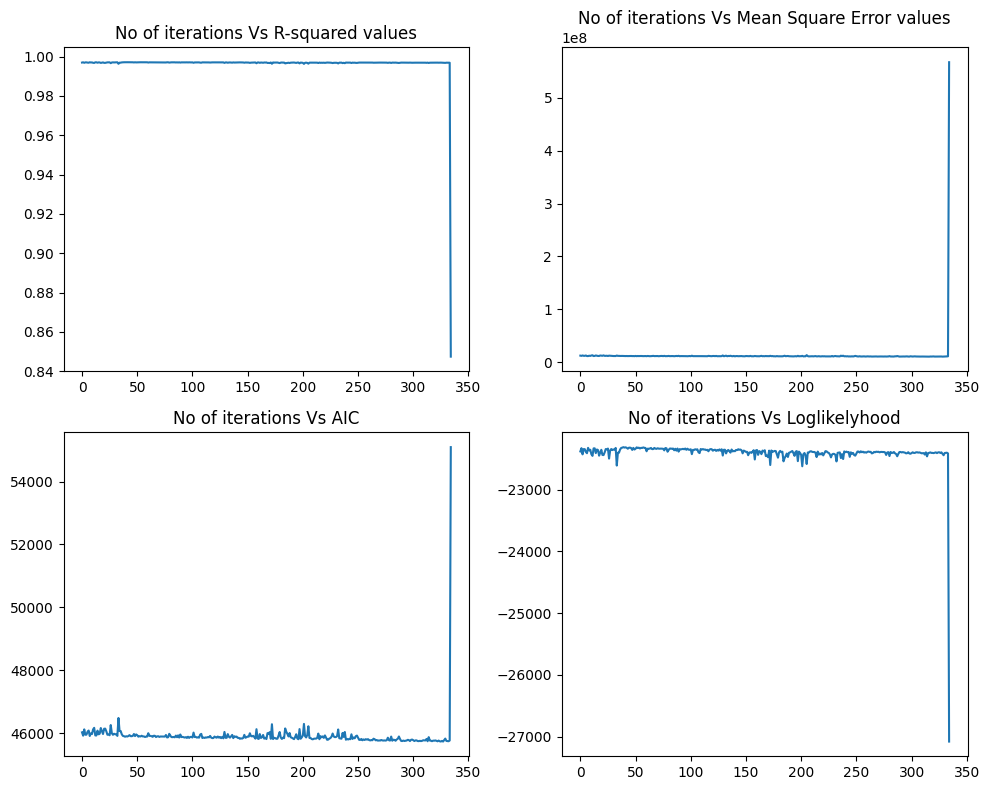

In [15]:
# plotting the metric curve
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

# Plot data on each subplot
axes[0, 0].plot(be_r2_list)
axes[0, 0].set_title('No of iterations Vs R-squared values')

axes[0, 1].plot(be_mse_list)
axes[0, 1].set_title('No of iterations Vs Mean Square Error values')

axes[1, 0].plot(be_aic_list)
axes[1, 0].set_title('No of iterations Vs AIC')

axes[1, 1].plot(be_loglikelyhood_list)
axes[1, 1].set_title('No of iterations Vs Loglikelyhood')

plt.tight_layout()
plt.show()


###  A. Optimal model metrics on obtained coefficients

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_combination_ohe[be_selected_features], y, test_size=0.2, random_state=42)
y_pred = be_optimal_model.predict(sm.add_constant(X_test))
aic_score = be_optimal_model.aic
mse = np.mean((y_test - y_pred)**2)
r2 = be_optimal_model.rsquared
llf = be_optimal_model.llf

print("Backward Elimination Optimal R-squared value:", r2)
print("Backward Elimination Optimal MSE:", mse)
print("Backward Elimination Optimal AIC Score:", aic_score)
print("Backward Elimination Optimal Log likelyhood",llf)

Backward Elimination Optimal R-squared value: 0.9968725611224529
Backward Elimination Optimal MSE: 10992286.60386934
Backward Elimination Optimal AIC Score: 45767.556754051475
Backward Elimination Optimal Log likelyhood -22414.778377025737


### B ) Final feature set from coefficients

In [18]:
be_selected_features_sorted_dict = sorted(be_optimal_model.pvalues.items(), key=lambda x: x[1])
be_selected_features_sorted = [t[0] for t in be_selected_features_sorted_dict]

be_feature_check_list = []
be_final_features = []
for key in be_selected_features_sorted:
    feature_terms = key.split("_")
    if len(feature_terms) == 2:
        if feature_terms[0] not in be_feature_check_list:
            be_final_features.append(feature_terms[0])
            be_feature_check_list.append(feature_terms[0])
    elif len(feature_terms) == 4:
        if feature_terms[0] not in be_feature_check_list and feature_terms[1] not in be_feature_check_list:
            be_final_features.append('_'.join(feature_terms[:2]))
            be_feature_check_list.append(feature_terms[0])
            be_feature_check_list.append(feature_terms[1])


print("Backward Elimination selected features: ", be_final_features)
print("Backward Elimination selected features in model notation: ",model_notation(be_final_features))

Backward Elimination selected features:  ['gender_maritalStatus', 'country_occupation', 'age_race', 'education', 'work']
Backward Elimination selected features in model notation:  S ~ A*R + C*O + E + G*M + W


### C) Fitting linear model on final features

In [19]:
be_X_combination_ohe = oh_encode_data(X_combination,be_final_features)
X_train, X_test, y_train, y_test = train_test_split(be_X_combination_ohe, y, test_size=0.2, random_state=42)
be_final_model = sm.OLS(y_train, sm.add_constant(X_train)).fit()
y_pred = be_final_model.predict(sm.add_constant(X_test))
aic_score = be_final_model.aic
mse = np.mean((y_test - y_pred)**2)
r2 = be_final_model.rsquared
llf = be_final_model.llf

print("Backward Elimination on linear model R-squared value:", r2)
print("Backward Elimination on linear model MSE:", mse)
print("Backward Elimination on linear model AIC Score:", aic_score)
print("Backward Elimination on linear model Optimal Log likelyhood",llf)

Backward Elimination on linear model R-squared value: 0.9966046193954184
Backward Elimination on linear model MSE: 9507045.454971386
Backward Elimination on linear model AIC Score: 45540.84021604434
Backward Elimination on linear model Optimal Log likelyhood -22513.42010802217
